<a href="https://colab.research.google.com/github/Jhancyamarsingh17/Automated-medical-report-generation-and-classification-/blob/main/Model_1_Inception_model_for_medical_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Dependencies

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [30]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Training Inception to extract features from x-ray images

In [31]:
bm = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                weights='imagenet',
                                               input_shape = (299, 299, 3))  

In [32]:
bm.trainable = True 

In [33]:
# Making the base model 
model_0 = tf.keras.Sequential(
    [
     tf.keras.layers.Input(shape = (299, 299, 3), name = "Input_layer"),
     bm,
     tf.keras.layers.GlobalMaxPool2D(),
     tf.keras.layers.Dense(12, activation = "softmax")
    ]
)


In [34]:
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 21,792,940
Non-trainable params: 34,432
_________________________________________________________________


### Loading in the model

In [35]:
## Visualizing the dataset 
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/indiana_reports.csv")
df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [36]:
dff = pd.read_csv("/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/indiana_projections.csv")
dff.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [37]:
dataframe = pd.merge(df, dff, on =['uid'])

In [38]:
dataframe = dataframe[dataframe.findings.notnull()]
dataframe.head()


,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
6,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal


In [39]:
len(dataframe)

6469

In [40]:
import string
import regex as re 
import nltk
from nltk.tokenize import word_tokenize


nltk.download('punkt')

def decontraction(doc):
    docs = re.sub(r"won't", "will not", doc)
    docs = re.sub(r"can\'t", "can not", docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have", docs)
    docs = re.sub(r"\'m", " am",docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have",docs)
    docs = re.sub(r"\'m", " am", docs)
    docs = re.sub(r"\*+", "abuse", docs)
    return docs


def text_preprocess(data):
  clean_text=[]
  text=str(data)

  text=text.lower()# making the text in lower case
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
  text=re.sub(r"xxxx","",text)# Removing the irrelavent XXXX words
  text=re.sub(r'xxx',"",text)
  text=re.sub(r'xx',"",text)
  text=re.sub(r'[0-9]',"",text)# Removing the number in text
  text = re.sub(r"yearold", "", text)
  text= re.sub('\s+',' ',text)
  text=re.sub("'",'',text)# Removing apoustahe
  text=re.sub(r'\.\.+', '.',text)# Removing multiple full stop
  text=re.sub(r'  ',"",text)
  text=decontraction(text)
 
  
  return text
#  
dataframe["indication"]=dataframe["indication"].apply(lambda x:text_preprocess(x))
dataframe["findings"]=dataframe["findings"].apply(lambda x:text_preprocess(x))
dataframe["impression"]=dataframe["impression"].apply(lambda x:text_preprocess(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
dataframe.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest x,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest x,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-2001.dcm.png,Lateral
6,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",with,None available,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis p...,4_IM-2050-1001.dcm.png,Frontal


In [42]:
images = dataframe["filename"].tolist()

In [43]:
findings = list(dataframe["findings"])


In [44]:
len(findings)

6469

In [45]:
try_captions = []
b = 0
for a in range(len(findings)):
  captions = str("<start> " + str(findings[a]) + " <end>")
  try_captions.append(captions)

In [46]:
train_captions = try_captions
image_paths = []
for img in images:
  path = "/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/" + img
  image_paths.append(path)

In [47]:
dataframe.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest x,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,the cardiac silhouette and mediastinum size ar...,normal chest x,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,2_IM-0652-2001.dcm.png,Lateral
6,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",with,None available,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis p...,4_IM-2050-1001.dcm.png,Frontal


In [48]:
##  checking on the image and caption arrays 
image_paths[:5]

['/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-4001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-3001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/2_IM-0652-1001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/2_IM-0652-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/4_IM-2050-1001.dcm.png']

In [49]:
train_captions[:5]

['<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax <end>',
 '<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax <end>',
 '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
 '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
 '<start> there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema there are irregular opacities in the left lung apex that could represent a cavitary lesion in the left lung apexthere are streaky opacities in the right upper lobe scarring the cardiomediastinal 

### Preparing the Model

In [50]:
image_model = bm


In [51]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [52]:
## Image feature Extractor Model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

extracted_image_features_model = tf.keras.Model(new_input, hidden_layer)

In [53]:
train_captions[:5], image_paths[:5]

(['<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax <end>',
  '<start> the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax <end>',
  '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
  '<start> borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  <end>',
  '<start> there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema there are irregular opacities in the left lung apex that could represent a cavitary lesion in the left lung apexthere are streaky opacities in the right upper lobe scarring the cardiomediast

In [54]:
# Get unique images
encode_train_image = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train_image)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in tqdm(image_dataset):
#   batch_features = extracted_image_features_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [55]:
report_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

max_length = 40
# Using the top 10000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,

    output_sequence_length=max_length,
    )
tokenizer.adapt(report_dataset)

In [56]:
path_to_glove_file = os.path.join("/content/gdrive/MyDrive/Data606_Capstone_project_folder/Copy of glove.6B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [57]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(vocabulary_size)))
hits = 0
misses = 0
embedding_dim = 300

# Preparing embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
       
        embedding_matrix[i] = embedding_vector
       

In [58]:
cap_vector = report_dataset.map(lambda x: tokenizer(x))

In [59]:
## Creating word to tokens and tokens to words mapping 
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [60]:
## Split data to training and testing 
import collections
import random
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and test sets using an 90-10 split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.9)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [61]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5822, 5822, 647, 647)

### Creating final data 

In [62]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
features_shape = 2560
attention_features_shape = 64

In [63]:
# Loading the saved numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [64]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch train data
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch validation data
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating the model

In [66]:

class CustomAttention(tf.keras.Model):
  def __init__(self, units):
    super(CustomAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

   
    # For unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [67]:
class CNN_Encoder(tf.keras.Model):
   
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [68]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = CustomAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention model
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [69]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [70]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [71]:
checkpoint_path = "/content/gdrive/MyDrive/Data606_Capstone_project_folder/shikha_epochs/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [72]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training 

In [73]:
loss_plot = []
val_loss_plot = []

In [74]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initialize the hidden state for each batch
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [75]:
@tf.function
def val_step(tensor, target):
    val_loss_ = 0  
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    
    with tf.GradientTape() as tape:
        features = encoder(tensor)
        #(batch_size,embedding_dim)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions_val,hidden,_ = decoder(dec_input, features,hidden)
            val_loss_ += loss_function(target[:, i], predictions_val)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i],1)
            

    return val_loss_


#  epochs

In [76]:
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_loss_val = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Train Loss: {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')   
    
    print('*'*100)

Epoch 1 Batch 0 Loss 5.3559
Epoch 1 Train Loss: 2.884198
Time taken for 1 epoch 299.24 sec

****************************************************************************************************
Epoch 2 Batch 0 Loss 2.0567
Epoch 2 Train Loss: 1.880572
Time taken for 1 epoch 128.48 sec

****************************************************************************************************
Epoch 3 Batch 0 Loss 1.8192
Epoch 3 Train Loss: 1.680069
Time taken for 1 epoch 128.16 sec

****************************************************************************************************
Epoch 4 Batch 0 Loss 1.6544
Epoch 4 Train Loss: 1.575416
Time taken for 1 epoch 128.38 sec

****************************************************************************************************
Epoch 5 Batch 0 Loss 1.6625
Epoch 5 Train Loss: 1.491544
Time taken for 1 epoch 127.91 sec

****************************************************************************************************
Epoch 6 Batch 0 Loss 1.4285
Epoch 6

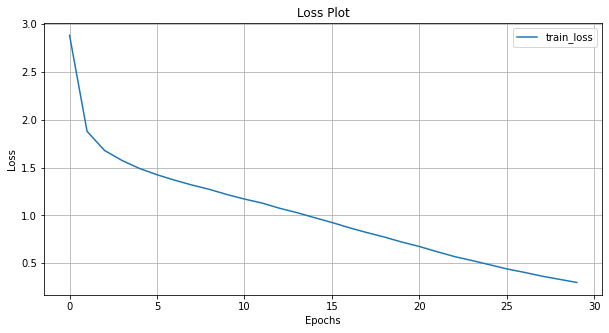

In [77]:

#plotting losses
plt.figure(figsize = (10,5))
plt.plot(loss_plot,label='train_loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Caption

In [78]:
def evaluate_model(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = extracted_image_features_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
   
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [79]:
def plot_attention_model(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

In [80]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

custom_sf = SmoothingFunction()

### Installing required functions to perform Named Entity Recognition

In [82]:
## Install scispaCy models
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.6 MB 1.9 MB/s 
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 660 kB 83.9 MB/s 
     |████████████████████████████████| 10.1 MB 86.6 MB/s 
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.4.0-py3-none-any.whl size=15660352 sha256=d40949863e1437e90fe1a3917d6bc1085c14be4789ca797bf3eedbb6c325badd
  Stored in directory: /root/.cache/pip/wheels/31/4b/3a/03f2732eb69789a7df3bf29c1bc010f660ada5f3c295d4073c
Successfully built en-core-sci-sm
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting un

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125.1 MB 65 kB/s 
  Created wheel for en-ner-craft-md: filename=en_ner_craft_md-0.4.0-py3-none-any.whl size=125689481 sha256=8368e6965532958255b05533b455bd0e1dd70d67b3101bad8c3a002afb00c00b
  Stored in directory: /root/.cache/pip/wheels/dd/f9/93/049ab5343fded423d6a809bcf595f4cfdd955404382fa8f085
Successfully built en-ner-craft-md
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125.1 MB 50 kB/s 
  Created wheel for en-ner-jnlpba-md: filename=en_ner_jnlpba_md-0.4.0-py3-none-any.whl size=125691807 sha256=f79c3e16d69cacef64ff43d43563ad2b7b75c169b51e6baf36c18e472cf7c784
  Stored in directory: /root/.cache/pip/wheels/ed/83/4a/2e7f532ded1476eb3750f2dec8ae8e1ebd0d890ca29c9146c7
Successfully built en-ner-jnlpba-md
Looking in indexes: https://pypi.org/simple, https://us

In [83]:
!pip install -U spacy
!pip install scispacy



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 4.8 MB/s 
     |████████████████████████████████| 806 kB 78.6 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.0.8
    Uninstalling spacy-3.0.8:
      Successfully uninstalled spacy-3.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-jnlpba-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.3 which is incompatible.
en-ner-craft-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.3 which is incompatible.
en-ner-bionlp13cg-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.3 which is incompatible.
en-ner

In [84]:
import scispacy
import spacy

#Core models
import en_core_sci_sm
import en_core_sci_lg

#NER specific models
import en_ner_craft_md
import en_ner_bc5cdr_md
import en_ner_jnlpba_md
import en_ner_bionlp13cg_md

#Tools for extracting & displaying data
from spacy import displacy

/usr/local/lib/python3.7/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.7/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.7/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_ner_craft_md' (0.4.0) was trained with s

In [85]:
def display_NER(result):
  nlp = en_ner_bc5cdr_md.load()
  doc = nlp(result)
  #Display resulting entity extraction
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

def pipeline_NER(result):
  nlp_en = en_ner_bc5cdr_md.load()
  nlp_xx = en_ner_bionlp13cg_md.load()
  nlp_en.add_pipe("ner", name="ner_xx", source=nlp_xx)
  doc = nlp_en(result)
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

## Predicting the report from X-ray image and generate Named entity from the generated report using NER.

rid 622
bleu score is  0.18393972058572117
Real report:  lungs are clear bilaterallythere is no focal consolidation pleural effusion or pneumothoraces cardiomediastinal silhouette is within normal limits are unremarkable
Predicted report:  there are no pneumonia effusions edema pneumothorax or effusion osseous structures are intact visualized bony structures show an unchanged cardiomediastinal silhouette and pulmonary vasculature are within normal limits for appearance the th right epicardial fat as well as well as


TEXT START END ENTITY TYPE
pneumonia 13 22 DISEASE
edema 33 38 PATHOLOGICAL_FORMATION
effusion osseous structures 55 82 DISEASE
pulmonary vasculature 172 193 MULTI_TISSUE_STRUCTURE
epicardial fat 247 261 TISSUE


TEXT START END ENTITY TYPE
pneumonia 13 22 DISEASE
effusion osseous structures 55 82 DISEASE


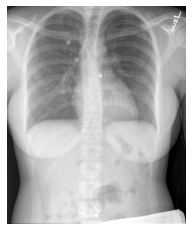

In [86]:
rid = np.random.randint(0, len(img_name_val))
print('rid', rid)
image = img_name_val[rid]
img = plt.imread(image)
plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)
real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]]
result, attention_plot = evaluate_model(image)
rem = ['startseq', 'start', 'end', 'endseq']
real_caption  = [x for x in real_caption if x not in rem]
result  = [x for x in result if x not in rem]
bl=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=custom_sf.method3)
print("bleu score is ",bl)
print('Real report: ', ' '.join([i for i in real_caption]))
print('Predicted report: ', ' '.join(result))
pipeline_NER(' '.join(result))
display_NER(' '.join(result))
# plot_attention_model(image, result, attention_plot)

### Calculating the performace of the model using BLEU Score on Test Data

In [ ]:

index=len(img_name_val)
cols = ['image', 'real','pred','bleu']
dat = pd.DataFrame(columns = cols)
bl=0
df_predicted_res = pd.DataFrame()
nums= len(img_name_val)
for j in range(nums):

  image = img_name_val[j]
  real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[j] if i not in [0]]
  
  result, attention_plot = evaluate_model(image)
  #removing the start and end tags we initially added
  rem = [ 'start', 'end']
  real_caption  = [x for x in real_caption if x not in rem]
  result  = [x for x in result if x not in rem]
  
  print('Real report: ', ' '.join([i for i in real_caption]))
  print('Predicted report: ', ' '.join(result))

  custom_sf = SmoothingFunction()
  bl+=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=custom_sf.method5)
  print('Bleu score: ', sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=custom_sf.method3))
  real_cap =  ' '.join([i for i in real_caption])
  pred_cap = ' '.join(result)
  dat = dat.append({'image': image, 'real':real_cap,'pred':pred_cap,'blue':bl},ignore_index=True)
  pipeline_NER(' '.join(result))
  display_NER(' '.join(result))
  print('*'*100)
print("average bleu score on the test data is ",bl/nums)
dat.to_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/shikha_real_vs_predicted.csv')

Real report:  the heart and mediastinum are normal the lungs are clear there is mild blunting of the right costophrenic there is no infiltrate mass or pneumothorax the right internal jugular catheter has been removed
Predicted report:  the are grossly intact or scarring the remainder of the and soft tissues are unremarkable or nodule in the left upper quadrant of the right lateral view the pleural spaces are clear or focal airspace opacities are
Bleu score:  0.2952820109759023


TEXT START END ENTITY TYPE
soft tissues 60 72 TISSUE
pleural 157 164 ORGAN
airspace opacities 191 209 DISEASE


TEXT START END ENTITY TYPE
airspace opacities 191 209 DISEASE
****************************************************************************************************
Real report:  frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette normal mediastinal contour pulmonary and vasculature central airways and lung volumes no pleural effusion
Predicted report:  there are no focal airspace consolidation no pleural effusion or pneumothorax there are no upper abdomen are normal pulmonary vascularity within normal limits there is no focal consolidation or pleural effusion there are no acute pulmonary edema no pneumothorax or
Bleu score:  0.14330626211475786


TEXT START END ENTITY TYPE
focal airspace 13 27 CELLULAR_COMPONENT
pleural effusion 45 61 DISEASE
pneumothorax 65 77 DISEASE
abdomen 97 104 ORGAN
pulmonary 116 125 ORGAN
pleural effusion 194 210 DISEASE
acute pulmonary edema 224 245 DISEASE
pneumothorax 249 261 DISEASE


TEXT START END ENTITY TYPE
pleural effusion 45 61 DISEASE
pneumothorax 65 77 DISEASE
pleural effusion 194 210 DISEASE
acute pulmonary edema 224 245 DISEASE
pneumothorax 249 261 DISEASE
****************************************************************************************************
Real report:  heart size is normal the lungs are clear there are no focal air space consolidations no pleural effusions or pneumothoraces the hilar and mediastinal contours are normal normal pulmonary vascularity
Predicted report:  the heart and cardiomediastinal silhouette are within normal limits bony thorax and soft tissues are grossly intact or scarring the midlower thoracic spine above the right sided perihilar opacities are excluded along the right lower lobe no acute
Bleu score:  0.25530944612154954


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
thorax 73 79 ORGAN
soft tissues 84 96 TISSUE


/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:206: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


TEXT START END ENTITY TYPE
****************************************************************************************************
Real report:  the lungs are clear there is no focal airspace consolidation no suspicious pulmonary mass or nodule is identified there is no pleural effusion or pneumothorax heart size and mediastinal contour are within normal limits
Predicted report:  the heart size is normal in size limits are unremarkable or infiltrate no focal airspace consolidation pleural effusion no pneumothorax no definite pleural effusions the interval both lungs are clear are normal no acute findings there are degenerative changes
Bleu score:  0.5331796216216278


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
focal airspace 74 88 CELLULAR_COMPONENT
pleural effusion 103 119 DISEASE
pneumothorax 123 135 DISEASE
pleural effusions 148 165 DISEASE
lungs 184 189 ORGAN
degenerative changes 239 259 DISEASE


TEXT START END ENTITY TYPE
pleural effusion 103 119 DISEASE
pneumothorax 123 135 DISEASE
pleural effusions 148 165 DISEASE
degenerative changes 239 259 DISEASE
****************************************************************************************************
Real report:  the heart size is normal and cardiomediastinal silhouette is normal in contour lungs are clear bilaterally there is no pleural effusion or pneumothorax no bony or soft tissue abnormalities
Predicted report:  the heart is normal in size the mediastinum is unremarkable the lungs are clear bilaterally no pleural effusions or pneumothoraces heart and mediastinum normal or prior granulomatous disease heart size within normal limits scattered bilateral granulomas heart size within
Bleu score:  0.4152352415927635


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
mediastinum 32 43 ORGAN
lungs 64 69 ORGAN
pleural effusions 95 112 DISEASE
heart and mediastinum normal 131 159 DISEASE
granulomatous disease 169 190 DISEASE
heart 191 196 ORGAN
granulomas 243 253 DISEASE
heart 254 259 ORGAN


TEXT START END ENTITY TYPE
pleural effusions 95 112 DISEASE
heart and mediastinum normal 131 159 DISEASE
granulomatous disease 169 190 DISEASE
granulomas 243 253 DISEASE
****************************************************************************************************
Real report:  the heart is normal in size the mediastinum is unremarkable mild pectus excavatum deformity is noted the lungs are clear
Predicted report:  the heart is normal in size and contour lungs are clear or airspace disease the lungs are clear bony structures are normal the lungs are clear or airspace disease the lungs are clear of focal airspace disease no
Bleu score:  0.22361331285732955


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
lungs 40 45 ORGAN
airspace disease 59 75 DISEASE
lungs 80 85 ORGAN
lungs 127 132 ORGAN
airspace disease 146 162 DISEASE
lungs 167 172 ORGAN
airspace disease 192 208 DISEASE


TEXT START END ENTITY TYPE
airspace disease 59 75 DISEASE
airspace disease 146 162 DISEASE
airspace disease 192 208 DISEASE
****************************************************************************************************
Real report:  the cardiomediastinal silhouette is within normal limits for size and contour the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax osseous structures are within normal limits for patient age
Predicted report:  the heart and cardiomediastinal silhouette are within normal limits the lungs are clear heart size within normal limits negative for pneumoperitoneum there is no focal airspace disease pleural effusion or pneumothorax cardiomediastinal silhouette is unremarkable visualized osseous structures appear intact
Bleu score:  0.6439664398144207


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
lungs 72 77 ORGAN
heart 88 93 ORGAN
airspace disease pleural effusion 168 201 DISEASE
pneumothorax 205 217 DISEASE


TEXT START END ENTITY TYPE
airspace disease pleural effusion 168 201 DISEASE
pneumothorax 205 217 DISEASE
****************************************************************************************************
Real report:  compared to prior examination stent has been removed cardiomediastinal silhouette is stable and within normal limits stable mild atherosclerotic calcifications of the aortic are noted there are mildly low lung volumes without focal consolidation pneumothorax or effusion identified no
Predicted report:  the heart is mild eventration of the posterior soft tissues of the heart size clear lungs no pneumothorax no pleural effusion or infiltrate no pneumothorax or pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the chest
Bleu score:  0.23076923076923078


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
eventration of the posterior soft 18 51 DISEASE
heart 67 72 ORGAN
lungs 84 89 ORGAN
pneumothorax 93 105 DISEASE
pleural effusion 109 125 DISEASE
pleural effusion cardio mediastinal 159 194 DISEASE


TEXT START END ENTITY TYPE
eventration of the posterior soft 18 51 DISEASE
pneumothorax 93 105 DISEASE
pleural effusion 109 125 DISEASE
pleural effusion cardio mediastinal 159 194 DISEASE
****************************************************************************************************
Real report:  the pulmonary nodules and masses masses on previous exam are smaller and not definitely seen the lungs are otherwise clear heart size normal no pneumothorax there is a right chest with tip projecting over the lower svc
Predicted report:  the heart is normal in size and contour the lungs are clear or focal consolidation mild cardiomegaly bony thorax is unremarkable or focal pleural effusions no evidence of focal airspace disease pneumothorax or pleural effusion identified however lungs
Bleu score:  0.3156761950765144


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
lungs 44 49 ORGAN
focal 63 68 CELLULAR_COMPONENT
cardiomegaly 88 100 DISEASE
thorax 106 112 ORGAN
pleural effusions 138 155 DISEASE
focal airspace disease pneumothorax 171 206 DISEASE
pleural effusion 210 226 DISEASE
lungs 246 251 ORGAN


TEXT START END ENTITY TYPE
cardiomegaly 88 100 DISEASE
pleural effusions 138 155 DISEASE
focal airspace disease pneumothorax 171 206 DISEASE
pleural effusion 210 226 DISEASE
****************************************************************************************************
Real report:  the cardiac and mediastinal silhouette is normal there is no evidence of pneumomediastinum or pneumothorax clear lungs there are no large pleural effusions no evidence of displaced fractures
Predicted report:  the cardiomediastinal silhouette is unremarkable no focal consolidation or pleural effusion surgical clips are unremarkable in size the mediastinum is within normal limits no focal consolidation pneumothorax or pleural effusion heart size within normal limits or rib the
Bleu score:  0.27487135396880114


TEXT START END ENTITY TYPE
pleural effusion 75 91 DISEASE
mediastinum 136 147 ORGAN
pleural effusion 211 227 DISEASE
heart 228 233 ORGAN
rib 263 266 ORGAN


TEXT START END ENTITY TYPE
pleural effusion 75 91 DISEASE
pleural effusion 211 227 DISEASE
****************************************************************************************************
Real report:  the cardiomediastinal silhouette and vasculature are within normal limits for size and contour the lungs are normally inflated and clear no definite pneumothorax no displaced fracture small rounded radiopaque density within the posterior superficial subcutaneous fat represents projectile fragment
Predicted report:  apparent cardiomegaly no focal areas of pulmonary consolidation or rib fractures appear enlarged the cardiomediastinal contours are within normal limits no focal consolidation no evidence of pneumothorax the cardiac and mediastinal contours clear lungs no pleural fluid is the
Bleu score:  0.3589743589743589


TEXT START END ENTITY TYPE
cardiomegaly 9 21 DISEASE
pulmonary 40 49 ORGAN
rib 67 70 ORGANISM_SUBDIVISION
fractures 71 80 DISEASE
pneumothorax 191 203 DISEASE
cardiac and mediastinal contours clear lungs no pleural fluid 208 269 DISEASE


TEXT START END ENTITY TYPE
cardiomegaly 9 21 DISEASE
fractures 71 80 DISEASE
pneumothorax 191 203 DISEASE
cardiac and mediastinal contours clear lungs no pleural fluid 208 269 DISEASE
****************************************************************************************************
Real report:  streaky and patchy bibasilar opacities triangular density projected over the heart on the lateral view no definite pleural effusion seen no typical findings of pulmonary edema considering differences in technical factors stable cardiomediastinal silhouette with normal heart size
Predicted report:  mildly hyperinflated heart size or infiltrate no definite pleural effusion seen no typical findings of pulmonary edema healed granulomatous disease stable no focal consolidation pleural effusion or pneumothorax seen accounting for technical factors heart size mildly to
Bleu score:  0.4473684210526316


TEXT START END ENTITY TYPE
hyperinflated 7 20 DISEASE
heart 21 26 ORGAN
pleural effusion 58 74 DISEASE
pulmonary edema 103 118 DISEASE
granulomatous disease 126 147 DISEASE
pleural effusion 178 194 DISEASE
pneumothorax 198 210 DISEASE
heart 249 254 ORGAN


TEXT START END ENTITY TYPE
hyperinflated 7 20 DISEASE
pleural effusion 58 74 DISEASE
pulmonary edema 103 118 DISEASE
granulomatous disease 126 147 DISEASE
pleural effusion 178 194 DISEASE
pneumothorax 198 210 DISEASE
****************************************************************************************************
Real report:  the trachea is midline the cardiomediastinal silhouette is normal and unchanged compared to prior examination tubular densities overlying the heart are coronary artery stents there are small round calcific densities in the bilateral lobes which are unchanged from prior
Predicted report:  lung volumes are low no evidence of acute infiltrate or large pleural effusion limited lateral projection the cardiomediastinal silhouette is upper limits of normal in size the mediastinum is stable the pulmonary and vasculature central airways and aeration of the
Bleu score:  0.2999030503717391
